# examp_oce_offline_isopycnal_transport: Offline derivation of isopycnal transport

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pyicon as pyic
import xarray as xr
import cartopy.crs as ccrs
import cmocean
from scipy.interpolate import interp1d
import regionmask

import seawater as sw

----Start loading pyicon.
----Start loading pyicon.
----Pyicon was loaded successfully.
----Pyicon was loaded successfully.


## Preparing data and grid

In [3]:
# run = 'nib0003_lay'
# path_data = f'/work/mh0033/m300602/proj_vmix/icon/icon_23/icon-oes-trr181-layers/experiments/{run}/'
# # tstr = '*'

run = 'nib2334'
path_data = f'/work/mh0033/m300602/proj_vmix/icon/icon_23/icon-oes-trr181-layers-02/experiments/{run}_c20/'
tstr = '20100101T000000Z'

# run = 'nib0001'
# path_data = f'/work/mh0033/m300602/proj_vmix/icon/icon_layers/feature-ocean-layers/experiments/{run}/'
# tstr = '*'

In [4]:
# # for R2B4
# ds_fx = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b4_oce_r0004/r2b4_oce_r0004_L40_fx.nc')
# ds_fx = ds_fx.rename(ncells='cell', ncells_2='edge', depth='depthc', depth_2='depthi')
# ds_tg = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b4_oce_r0004/r2b4_oce_r0004_tgrid.nc')

# for R2B6
ds_fx = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b6_oce_r0004/r2b6_oce_r0004_L64_fx.nc')
ds_fx = ds_fx.rename(ncells='cell', ncells_2='edge', depth='depthc', depth_2='depthi')
ds_tg = xr.open_dataset('/work/mh0033/m300602/icon/grids/r2b6_oce_r0004/r2b6_oce_r0004_tgrid.nc')

In [5]:
ds_IcD = pyic.convert_tgrid_data(ds_tg)

In [6]:
ds_3d = xr.open_mfdataset(f'{path_data}/{run}_P1Y_3d_{tstr}.nc')
ds_3d = ds_3d.rename(ncells='cell', ncells_2='edge', depth='depthc', depth_2='depthi')
ds_3d = ds_3d.isel(time=-1)

In [7]:
mass_flux = ds_3d.mass_flux.compute()
to = ds_3d.to.compute()
so = ds_3d.so.compute()

## Sigma2 and isopycnal levels

In [8]:
sigma2 = xr.DataArray(sw.dens(so, to, 2000) - 1000., coords=to.coords)

In [9]:
# sigma2 on edges
rho_e = sigma2.isel(cell=ds_IcD.adjacent_cell_of_edge).mean(dim='nc_e')

In [10]:
rho_lev = np.array([
        0.   , 30.   , 31.   , 32.   , 33.   , 33.2  , 33.4  , 33.6  ,
       33.8  , 34.   , 34.2  , 34.4  , 34.6  , 34.8  , 35.   , 35.2  ,
       35.4  , 35.6  , 35.8  , 36.   , 36.05 , 36.1  , 36.15 , 36.2  ,
       36.25 , 36.3  , 36.35 , 36.4  , 36.45 , 36.5  , 36.55 , 36.6  ,
       36.65 , 36.7  , 36.75 , 36.76 , 36.78 , 36.8  , 36.82 , 36.84 ,
       36.86 , 36.88 , 36.9  , 36.92 , 36.94 , 36.96 , 36.98 , 37.   ,
       37.01 , 37.02 , 37.03 , 37.04 , 37.045, 37.05 , 37.055, 37.06 ,
       37.065, 37.07 , 37.075, 37.08 , 37.085, 37.09 , 37.095, 37.1  ,
       37.105, 37.11 , 37.115, 37.12 , 37.125, 37.13 , 37.135, 37.14 ,
       37.145, 37.15 , 37.155, 37.16 , 37.165, 37.17 , 37.175, 37.18 ,
       37.185, 37.19 , 37.195, 37.2  , 42.  
])

In [11]:
n_dlev = rho_lev.size - 1
nc, ne, nv = ds_IcD.clon.size, ds_IcD.elon.size, ds_IcD.vlon.size

In [12]:
# some isopycnal levels and corresponding indices for plotting
isos = [36.85, 36.92, 36.96, 37.0]
for kk, iso in enumerate(isos):
    kiso = np.argmin((rho_lev-iso)**2)
    print(rho_lev[kiso])

36.84
36.92
36.96
37.0


## Derive isopycnal transport

In [13]:
mass_flux_lay = np.zeros((n_dlev, ne))
layer_thickness_e = np.zeros((n_dlev, ne))

In [14]:
dze = ds_fx.prism_thick_e

In [15]:
%%time
for dd in range(n_dlev):
    print(f'dd = {dd} / {n_dlev}', end='\r')
    mask_lay = ((rho_e>rho_lev[dd]) & (rho_e<=rho_lev[dd+1])).astype(float)
    mass_flux_lay[dd,:] = (mass_flux.data * mask_lay).sum(axis=0)
    layer_thickness_e[dd,:] = (dze.data * mask_lay).sum(axis=0)

CPU times: user 32 s, sys: 27.3 s, total: 59.2 s
Wall time: 59.5 s


In [16]:
mass_flux_lay = xr.DataArray(mass_flux_lay, dims=['lev', 'edge'])
layer_thickness_e = xr.DataArray(layer_thickness_e, dims=['lev', 'edge'])

## Diapycnal velocities from isopycnal transport

In [17]:
# divergence of isopycnal mass flux
div_coeff = pyic.xr_calc_div_coeff(ds_IcD)
div_mass_flux_lay = pyic.xr_calc_div(ds_IcD, mass_flux_lay, div_coeff)

In [18]:
# vertically sum divergence of isopycnal mass flux to obtain diapycnal velocity
da = -div_mass_flux_lay[::-1,:].cumsum(dim='lev')[::-1,:]
diapycnal_velocity = xr.DataArray(np.zeros((n_dlev+1, nc)), dims=['lev_2', 'cell'])
diapycnal_velocity[:-1,:] = da[:,:]

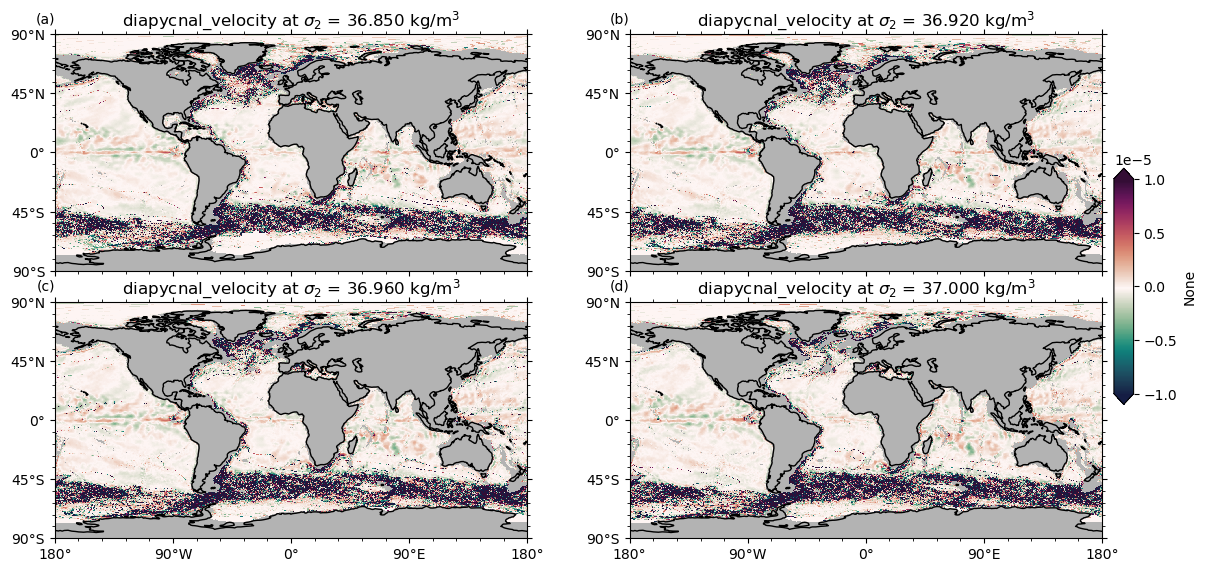

In [19]:
P = pyic.Plot(2, 2, plot_cb='right', projection=ccrs.PlateCarree())

for kk, iso in enumerate(isos):
    ax, cax = P.next()
    kiso = np.argmin((rho_lev-iso)**2)

    da = diapycnal_velocity.isel(lev_2=kiso).compute()
    P.plot(da, clim=10e-6, cmap=cmocean.cm.curl)
    ax.set_title(f'diapycnal_velocity at $\sigma_2$ = %.3f kg/m$^3$' % (iso))
    ax.set_title('', loc='left')
    ax.set_title('', loc='right')

## Isopycnal MOC

In [20]:
# makes a nice plot of isopycnal streamfunction in density space
def plot_dmoc(dmoc, rho_lev, clim=None, norm=None, contfs=None, conts=None, cbticks=None, ax=0, cax=0):
    fac = 1.
    remap_d2r=np.hstack([0.00, 
                         np.arange(30.00, 35.99, 1.00/fac),
                         np.arange(36.00, 36.64, 0.20/fac),# 0.15
                         np.arange(36.65, 36.91, 0.05/fac),
                         np.arange(36.92, 37.04, 0.02/fac),
                         np.arange(37.05, 38.50, 0.25/fac),
                         44.00])
    remap_d2r = np.sort(np.unique(remap_d2r))
    remap_d2r_major = np.array([30.00, 36.00, 36.65, 36.92, 37.05])
    reg      = np.linspace(0, len(remap_d2r), len(remap_d2r))
    reg      = reg[::-1]
    dens2reg = interp1d(remap_d2r, reg      , kind='linear')
    reg2dens = interp1d(reg      , remap_d2r, kind='linear')
    
    reg_lev = dens2reg(rho_lev)

    # hm = pyic.shade(lat_mg, reg_lev, dmoc/1e6, ax=ax, cax=cax, clim=clevs[-1], conts=conts)
    hm = pyic.shade(lat_mg, reg_lev, dmoc/1e6, ax=ax, cax=cax, clim=clim, norm=norm, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
    # hm = pyic.shade(lat_mg, reg_lev, dmoc/1e6, ax=ax, cax=cax, clim=clevs[-1], conts=clevs_sp, contcolor='k', use_pcol=False)
    # ax.clabel(hm[1], fontsize=8, fmt='%.1fSv')
    Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
    # for txt in Cl:
    #   txt.set_bbox(dict(facecolor='white', edgecolor='none', pad=0))

    xy, x_ind, y_ind = np.intersect1d(remap_d2r, remap_d2r_major, return_indices=True)
    # --> this will become major tick marks (larger fontsize)
    ymajorticks = reg[x_ind] 
    ax.set_yticks( ymajorticks, minor=False ) 

    ymajorlabel_list = np.around(reg2dens(ymajorticks), 3).tolist()
    ylabelmayjor_list_fmt=list()
    for num in ymajorlabel_list: ylabelmayjor_list_fmt.append('{:2.2f}'.format(num))
    ax.set_yticklabels(ylabelmayjor_list_fmt, minor=False, size = 10)

    # --> this will become minor tick marks (smaller fontsize)
    yminorticks = np.setdiff1d(reg[1:-1], ymajorticks)
    ax.set_yticks( yminorticks, minor=True )

    yminorlabel_list = np.around(reg2dens(yminorticks), 3).tolist()
    ylabelminor_list_fmt=list()
    for num in yminorlabel_list: ylabelminor_list_fmt.append('{:2.2f}'.format(num))
    ax.set_yticklabels(ylabelminor_list_fmt, minor=True, size = 6)
    
    ax.grid(True)
    return

In [21]:
# latitude bands for zonal average
clat = ds_IcD.clat
lat_group = np.round(clat/0.3)*0.3

In [22]:
# derive global MOC, Atlantic MOC and Indo-Pacific MOC in density space
wdTransp = diapycnal_velocity*ds_IcD.cell_area
wdTransp = wdTransp.compute()
wdTransp = wdTransp.where(np.isfinite(wdTransp))

gmoc_d = -(wdTransp.groupby(lat_group).sum())[:,::-1].cumsum(dim='clat')[:,::-1]
amoc_d = -(wdTransp.where(ds_fx.basin_c==1.).groupby(lat_group).sum())[:,::-1].cumsum(dim='clat')[:,::-1]
ipsomoc_d = -(wdTransp.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).sum())[:,::-1].cumsum(dim='clat')[:,::-1]
lat_mg = gmoc_d.clat

Text(0.5, 1.0, 'Indo-Pacific isopycnal streamfunction / Sv')

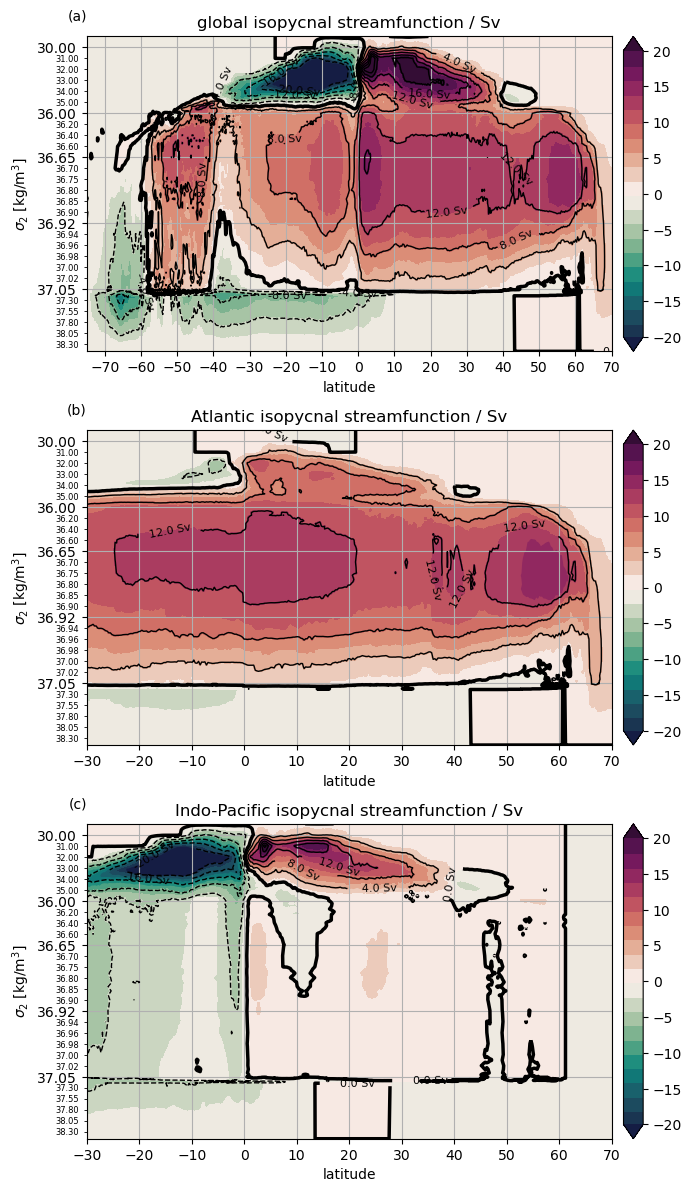

In [23]:
P = pyic.Plot(1, 3, asp=0.6, fig_size_fac=2, sharex=False, xlabel='latitude', ylabel='$\sigma_2$ [kg/m$^3$]')

clim = 20
contfs = np.arange(-clim, clim+1, 2)
conts = np.arange(-clim, clim+5, 4)
cbticks = np.arange(-20,21,5)

ax, cax = P.next()
plot_dmoc(gmoc_d, rho_lev, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cbticks=cbticks)
ax.set_xticks(np.arange(-90,100,10))
ax.set_xlim(-75,70)
ax.set_title('global isopycnal streamfunction / Sv')

ax, cax = P.next()
plot_dmoc(amoc_d, rho_lev, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cbticks=cbticks)
ax.set_xticks(np.arange(-90,100,10))
ax.set_xlim(-30,70)
ax.set_title('Atlantic isopycnal streamfunction / Sv')

ax, cax = P.next()
plot_dmoc(ipsomoc_d, rho_lev, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cbticks=cbticks)
ax.set_xticks(np.arange(-90,100,10))
ax.set_xlim(-30,70)
ax.set_title('Indo-Pacific isopycnal streamfunction / Sv')

## Isopycnal MOC remapped to depth levels

In [24]:
# to remap isopycnal streamfunction from density space to depth space
def remap_isop_moc(gmoc_d, amoc_d, ipsomoc_d, lay_thick_e, ds_IcD, depthi):   
    # lay_thick_e = ds_lay.layer_thickness_e.compute()
    depth_lay_e = lay_thick_e.cumsum(dim='lev')
    depth_lay_e = depth_lay_e.where(lay_thick_e!=0.)
    
    # lay_thick_c = ds_lay.layer_thickness_c.compute()
    # depth_lay_c = lay_thick_c.cumsum(dim='lev')
    # depth_lay_c = depth_lay_c.where(lay_thick_c!=0.)
    depth_lay_c = depth_lay_e.isel(edge=ds_IcD.edge_of_cell).mean(dim='ne_c')
    depth_lay_c = depth_lay_c
    
    # --- filter Mediteranean from density layers
    if False:
        region = regionmask.defined_regions.ar6.ocean
        region_mask = region.mask(ds_IcD, lon_name='clon', lat_name='clat', wrap_lon=False)
        depth_lay_c = depth_lay_c.where(region_mask!=19)
    
    clat = ds_IcD.clat
    lat_group = np.round(clat/0.3)*0.3

    depth_lay_c_gzave = depth_lay_c.groupby(lat_group).mean()
    depth_lay_c_azave = depth_lay_c.where(ds_fx.basin_c==1.).groupby(lat_group).mean()
    depth_lay_c_ipzave = depth_lay_c.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).mean()
    lat_zave = depth_lay_c_gzave.clat
    
    depth_target = depthi
    # depth_target = np.linspace(0,depthi.max(),200)

    gmoc_dz = np.ma.zeros((depth_target.size, lat_zave.size))
    amoc_dz = np.ma.zeros((depth_target.size, lat_zave.size))
    ipmoc_dz = np.ma.zeros((depth_target.size, lat_zave.size))
    for jj in range(lat_zave.size):
        f = interp1d(depth_lay_c_gzave[:,jj], gmoc_d[1:,jj], bounds_error=False)
        gmoc_dz[:,jj] = f(depth_target)

        f = interp1d(depth_lay_c_azave[:,jj], amoc_d[1:,jj], bounds_error=False)
        amoc_dz[:,jj] = f(depth_target)

        f = interp1d(depth_lay_c_ipzave[:,jj], ipsomoc_d[1:,jj], bounds_error=False)
        ipmoc_dz[:,jj] = f(depth_target)
        
    lat = lat_mg
    return lat, gmoc_dz, amoc_dz, ipmoc_dz

In [25]:
depthi = ds_fx.depthi.data
lat, gmoc_dz, amoc_dz, ipmoc_dz = remap_isop_moc(gmoc_d, amoc_d, ipsomoc_d, layer_thickness_e, ds_IcD, depthi=depthi)

In [26]:
# derive maximum depth for masking remapped streamfunction
topo = (ds_fx.wet_c*ds_fx.prism_thick_c).sum(dim='depthc')

topo_gzave = topo.groupby(lat_group).mean()
topo_azave = topo.where(ds_fx.basin_c==1.).groupby(lat_group).mean()
topo_ipzave = topo.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).mean()

topo_gzmax = topo.groupby(lat_group).max()
topo_azmax = topo.where(ds_fx.basin_c==1.).groupby(lat_group).max()
topo_ipzmax = topo.where((ds_fx.basin_c==3.) | (ds_fx.basin_c==7.)).groupby(lat_group).max()

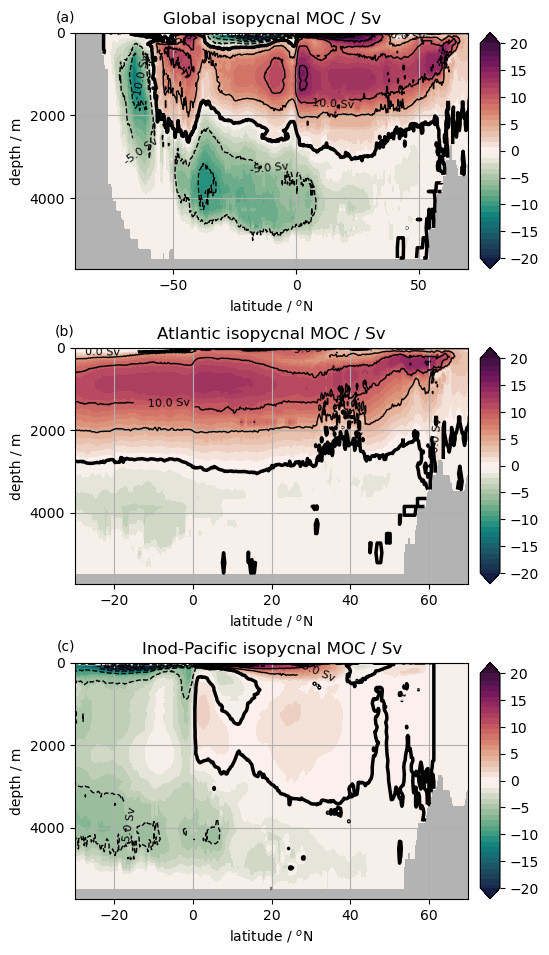

In [27]:
P = pyic.Plot(1, 3, asp=0.6, sharex=False, xlabel='latitude / $^o$N', ylabel='depth / m')

clim = 20
contfs = np.arange(-clim, clim+1, 1)
conts = np.arange(-clim, clim+5, 5)
cbticks = np.arange(-20,21,5)

ax, cax = P.next()
da = xr.DataArray(gmoc_dz/1e6, dims=['depth', 'clat'], coords=dict(depth=depthi, clat=lat))
da = da.where(da.isnull()==False,0)
da = da.where(da.depth<topo_gzmax)
hm = P.shade(lat, depthi, da, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
ax.set_title('Global isopycnal MOC / Sv')
ax.set_xlim(-90,70)

ax, cax = P.next()
da = xr.DataArray(amoc_dz/1e6, dims=['depth', 'clat'], coords=dict(depth=depthi, clat=lat))
da = da.where(da.isnull()==False,0)
da = da.where(da.depth<topo_gzmax)
hm = P.shade(lat, depthi, da, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
ax.set_title('Atlantic isopycnal MOC / Sv')
ax.set_xlim(-30,70)

ax, cax = P.next()
da = xr.DataArray(ipmoc_dz/1e6, dims=['depth', 'clat'], coords=dict(depth=depthi, clat=lat))
da = da.where(da.isnull()==False,0)
da = da.where(da.depth<topo_gzmax)
hm = P.shade(lat, depthi, da, ax=ax, cax=cax, clim=clim, contfs=contfs, conts=conts, cmap=cmocean.cm.curl, cbticks=cbticks)
Cl = ax.clabel(hm[1], colors='k', fontsize=8, fmt='%.1f Sv', inline=True)
ax.set_title('Inod-Pacific isopycnal MOC / Sv')
ax.set_xlim(-30,70)

for ax in P.hca:
    ax.invert_yaxis()
    ax.grid(True)
    ax.set_facecolor('0.7')